In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.


In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

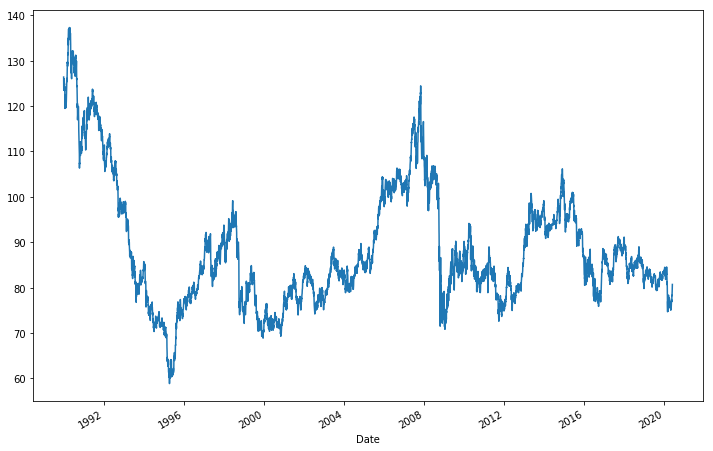

In [4]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot(figsize=(12,8))

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** There is a certain type of trend evrey three year.

---

# Decomposition Using a Hodrick-Prescott Filter

In [5]:
import statsmodels.api as sm

ts_noise, ts_trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])

In [6]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
price = {'Price': cad_jpy_df.Price, 'noise': ts_noise,'trend': ts_trend}
price_df = pd.DataFrame(price)
price_df.head()

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


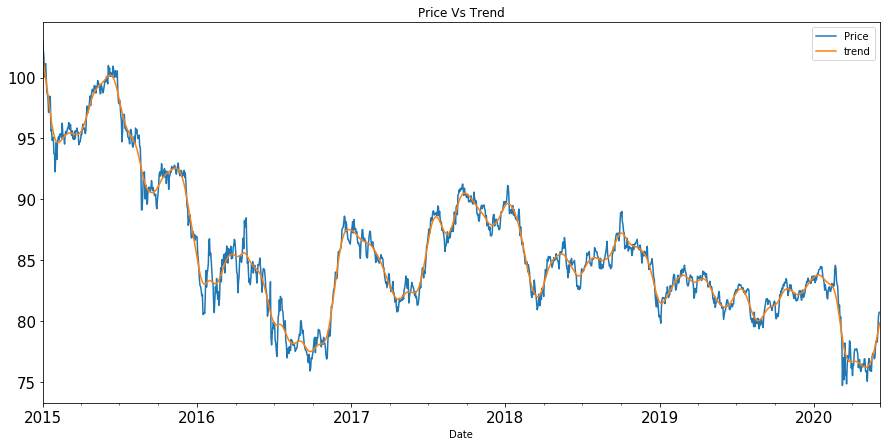

In [7]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
price_df[['Price', 'trend']].loc['2015':].plot(fontsize=15, figsize=(15,7),title="Price Vs Trend")

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** Price is gradually decreasing over the time from 2015 to 2020 though there's a sudden fall between 2016 and 2017 but price experienced sudden hike after the deep.

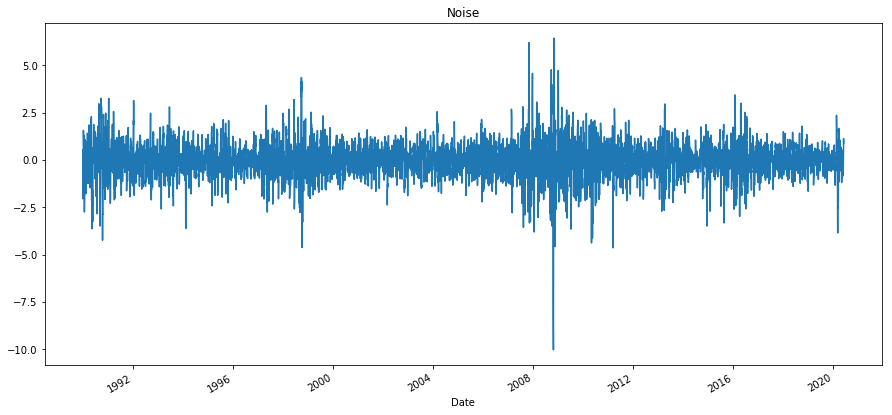

In [8]:
# Plot the Settle Noise
ts_noise.plot(figsize=(15,7), title="Noise")

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [10]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
# Estimate and ARMA model using statsmodels (use order=(2, 1))

arma_model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
arma_results = arma_model.fit()

In [11]:
# Output model summary results:
arma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Fri, 29 Oct 2021   AIC                          19513.955
Time:                        22:37:28   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1702           +0.0000j           42.1702            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

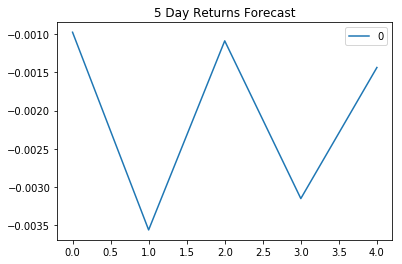

In [12]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(arma_results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

**Question:** Based on the p-value, is the model a good fit?

**Answer:** Based on the value model does not seems to be a good fit.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
arima_model = ARIMA(cad_jpy_df.Price.values, order=(5,1,1))

# Fit the model
arima_results = arima_model.fit()

In [14]:
# Output model summary results:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Fri, 29 Oct 2021   AIC                          17507.244
Time:                        22:37:31   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.y      0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.y      0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.y     -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.y      0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.y     -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.y     -0.4568      0.246     -1.856      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1893           +0.0000j            2.1893            0.0000
-----------------------------------------------------------------------------
"""

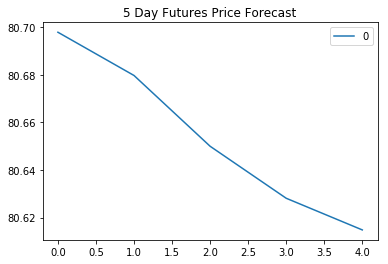

In [15]:
# Plot the 5 Day Price Forecast
pd.DataFrame(arima_results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** Based on the model forecast Japaneed Yen will become stronger against Canadian Dollar.

---

# Volatility Forecasting with GARCH


In [16]:
import arch as arch
from arch import arch_model

ModuleNotFoundError: No module named 'arch'

In [ ]:
# Estimate a GARCH model:
garch_model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
garch_result = garch_model.fit()

In [ ]:
# Summarize the model results
garch_result.summary()

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [ ]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

In [ ]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = garch_result.forecast(start='2020-06-04', horizon=forecast_horizon)
forecasts

In [ ]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

In [ ]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

In [ ]:
# Plot the final forecast
final.plot(title="5 Day Forecast Volatility")

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** According to forecast, coming days will expect higher volatility rate.

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

   **Answer -** Based on analysis, I would not prefer to buy Japanese Yen for now.

2. Is the risk of the yen expected to increase or decrease?

   **Answer -** Risk of yen expected to increase in coming days

3. Based on the model evaluation, would you feel confident in using these models for trading?

**Answer -** Well model seems prety deasent to me, but I believe I can improve it and in coming days we will be studying Algorithmic Trading so will prefer to utilize that concept in this model too.